# Assignment - Style Transfer

*AI VIET NAM* 

- Bạn cần hoàn thành các phần trong dấu:
```python
########### YOUR CODE HERE #################
###########################################
```

/tmp/ipykernel_6531/1033178603.py:4: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``np.array(PIL.Image.open(urllib.request.urlopen(url)))``.
  img = mpimg.imread("https://www.dropbox.com/s/8hhb4flk8e7p89i/img1.png?dl=1")


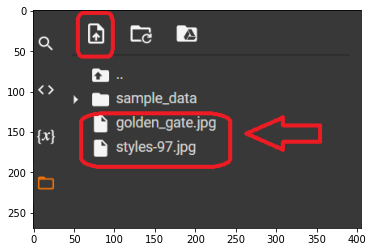

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("https://www.dropbox.com/s/8hhb4flk8e7p89i/img1.png?dl=1")
imgplot = plt.imshow(img)

# Phần 1: 


In [2]:
import tensorflow as tf

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools
import os
import copy
from scipy.ndimage import rotate

In [3]:
# Hyperparams
rotation_weight = 1.0
total_variation_weight = 30
style_weight=1e-2
content_weight=1e4
img_size = (422, 512)  #(H, W)

## Code các hàm xử lí ảnh đầu vào

In [9]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

204800/195196 [===============================] - 0s 1us/step


In [10]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [11]:
def load_img(path_to_img, img_size):
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  img = tf.image.resize(img, img_size)
  img = img[tf.newaxis, :]
  return img

In [12]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

(1, 422, 512, 3)
(1, 422, 512, 3)


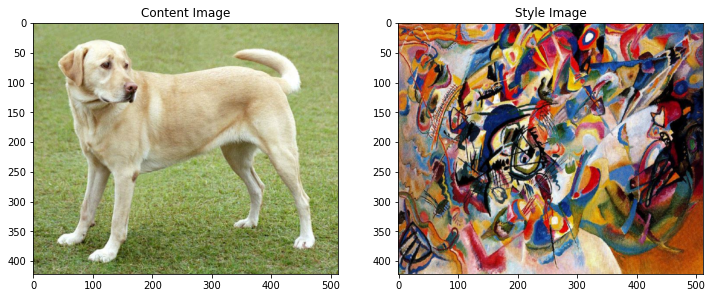

In [13]:
content_image = load_img(content_path, img_size)
style_image = load_img(style_path, img_size)

print(content_image.shape)
print(style_image.shape)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

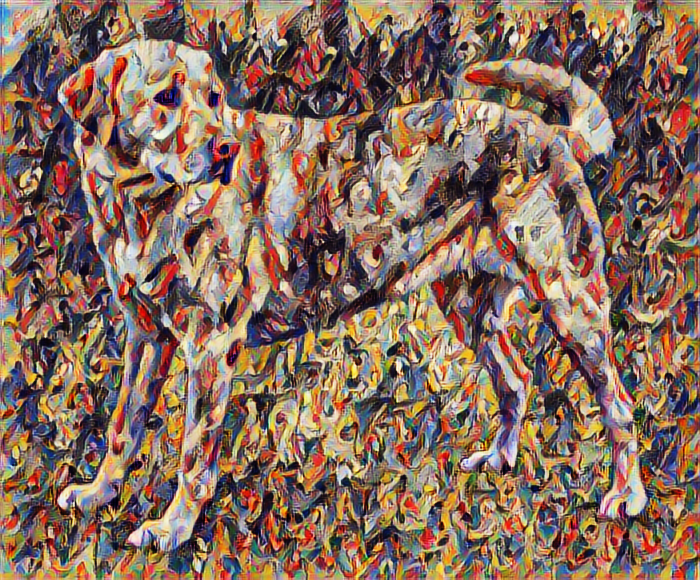

In [16]:
#Truyen nhanh kieu dang ban TFHub
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

## Tiến hành load model pretrain VGG19 từ Tensorflow

In [18]:
vgg_view = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg_view.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [17]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
content_layers = ['block5_conv2']
style_layers   = ['block1_conv1',
                  'block2_conv1',
                  'block3_conv1', 
                  'block4_conv1', 
                  'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers   = len(style_layers)

80150528/80134624 [==============================] - 10s 0us/step


In [20]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]
  model   = tf.keras.Model([vgg.input], outputs)
  return model

## Xây dựng hàm tính Gram matrix để lấy thông tin từ ảnh style

Mạng VGG19 sẽ biến ảnh $x_{0} \in \mathcal{R}^{W_{0} \times H_{0} \times 3}$ thành tập các feature map $\{F^l(x_{0}\}^L_{l=1}$, trong đó $F^l : \mathcal{R}^{W_{0} \times H_{0} \times 3} \rightarrow \mathcal{R}^{W_{l} \times H_{l} \times D_{l}}$. Thông tin style được tính bằng Gram matrix của feature map $F_{l}$ thuộc layer $l$.

Công thức tính Gram matrix:
$$[G^l(F^l)]_{ij} = \sum\limits_{k}^{} F^l_{ik}F^l_{jk}$$



In [21]:
def gram_matrix(input_tensor):
  ########### YOUR CODE HERE ################
  result = tf.linalg.einsum('bijc, bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/num_locations
  ###########################################

## DFR method
Sau khi qua model ta thu được tập các feature map, thực hiện xoay các feature theo các góc 90, 180, 270. Từ đó thấy được sự thay đổi của ảnh được sinh ra



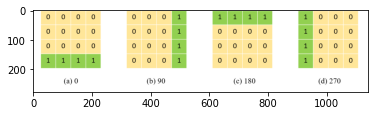

In [ ]:
img1 = mpimg.imread("https://www.dropbox.com/s/mp2o7d0miqa40gp/img2.png?dl=1")
imgplot = plt.imshow(img1)

In [ ]:
def rotation_tensor(inputs, angles = None):
    """Rotate tensor in 90, 180, 270 angles"""
    ########### YOUR CODE HERE ################
    if angles == 90:
        return tf.image.rot90(inputs)
    elif angles == 180:
        return tf.imag

    ###########################################
    pass

def extensive_rotation_tensor(inputs, angles = None):
    """Rotate tensor in arbitrary angles"""
    ########### YOUR CODE HERE ################
  
    ###########################################
    pass

## Xây dựng Model để thực hiện feature extraction

Sau khi xoay các feature map $W$, ta được tập hợp feature map mới $W_{r}$. Feature map cuối cùng được tổng hợp bằng công thức:
$$\hat{W_{r}} = (1 - \lambda)W + \lambda W_{r}$$

Với $\lambda$ được gọi là *rotation weight*

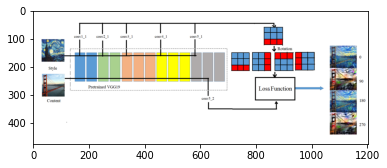

In [5]:
img2 = mpimg.imread("https://www.dropbox.com/s/f6x0k2vhxn2focj/img3.png?dl=1")
imgplot = plt.imshow(img2)

In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

In [ ]:
class StyleContentModel_style(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers, rotation_weight):
    super(StyleContentModel_style, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False
    self.rotation_weight = rotation_weight

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])
    
    # Rotation
    style_outputs_90 = ########### YOUR CODE HERE ################
    style_outputs_180 = ########### YOUR CODE HERE ###############
    style_outputs_270 = ########### YOUR CODE HERE ################
    
    style_outputs_1 = [gram_matrix(style_output)
                     for style_output in style_outputs]
    
    # Fusion
    style_outputs_2 = [(1 - self.rotation_weight) * gram_matrix(style_output1) + self.rotation_weight * gram_matrix(style_output2)
                     for style_output1, style_output2 in zip(style_outputs, style_outputs_90)]

    style_outputs_3 = ########### YOUR CODE HERE ################
  
                      ###########################################

    style_outputs_4 = ########### YOUR CODE HERE ################
  
                      ###########################################

    # Save feature
    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict_1 = ########### YOUR CODE HERE ################
  
                    ###########################################

    style_dict_2 = ########### YOUR CODE HERE ################
  
                  ###########################################

    style_dict_3 = ########### YOUR CODE HERE ################
  
                    ###########################################

    style_dict_4 = ########### YOUR CODE HERE ################
  
                    ###########################################
    
    return {'content':content_dict, 'style_1':style_dict_1, 'style_2':style_dict_2, 'style_3':style_dict_3, 'style_4':style_dict_4}

In [ ]:
extractor_style = StyleContentModel_style(style_layers, content_layers, rotation_weight = rotation_weight)
extractor       = StyleContentModel(style_layers, content_layers)

In [ ]:
style_targets_1 = extractor_style(style_image)['style_1']
style_targets_2 = extractor_style(style_image)['style_2']
style_targets_3 = extractor_style(style_image)['style_3']
style_targets_4 = extractor_style(style_image)['style_4']
content_targets = extractor(content_image)['content']

image = tf.Variable(content_image)
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

## Tổng hợp content loss và style loss

Hàm loss cuối cùng được biến đổi thành
$$ L(x) = \alpha L_{content}(x) + \beta L_{style}(x)$$
với
$$L_{content} (x) = \frac{1}{2}  \|F^l(x) - \hat{W_{r}}\|^2_{2}.$$
$$L_{style} (x) = \sum\limits_{l=1}^{L} \frac{w_{l}}{4D^2_{l}M^2_{l}} \|G^l(F^l(x)) - G^l(\hat{W_{r}})\|^2_{2}.$$

In [ ]:
def style_content_loss_1(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets_1[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

def style_content_loss_2(outputs):
    ########### YOUR CODE HERE ################
  
    ###########################################

def style_content_loss_3(outputs):
    ########### YOUR CODE HERE ################
  
    ###########################################

def style_content_loss_4(outputs):
    ########### YOUR CODE HERE ################
  
    ###########################################

In [ ]:
@tf.function()
def train_step(image_1, image_2, image_3, image_4):
  with tf.GradientTape() as tape_1, tf.GradientTape() as tape_2, tf.GradientTape() as tape_3, tf.GradientTape() as tape_4:
    outputs_1 = extractor(image_1)
    outputs_2 = extractor(image_2)
    outputs_3 = extractor(image_3)
    outputs_4 = extractor(image_4)

    loss_1 = style_content_loss_1(outputs_1)
    loss_2 = style_content_loss_2(outputs_2)
    loss_3 = style_content_loss_3(outputs_3)
    loss_4 = style_content_loss_4(outputs_4)

    loss_1 += total_variation_weight*tf.image.total_variation(image_1)
    loss_2 += total_variation_weight*tf.image.total_variation(image_2)
    loss_3 += total_variation_weight*tf.image.total_variation(image_3)
    loss_4 += total_variation_weight*tf.image.total_variation(image_4)

  grad_1 = tape_1.gradient(loss_1, image_1)
  grad_2 = tape_2.gradient(loss_2, image_2)
  grad_3 = tape_3.gradient(loss_3, image_3)
  grad_4 = tape_4.gradient(loss_4, image_4)

  opt.apply_gradients([(grad_1, image_1)])
  opt.apply_gradients([(grad_2, image_2)])
  opt.apply_gradients([(grad_3, image_3)])
  opt.apply_gradients([(grad_4, image_4)])

  image_1.assign(clip_0_1(image_1))
  image_2.assign(clip_0_1(image_2))
  image_3.assign(clip_0_1(image_3))
  image_4.assign(clip_0_1(image_4))

## Inference

Hình được sinh ra sẽ có sự biến đổi theo từng epoch, hãy thử thay đổi thêm các hyperparameter để theo dõi sự khác nhau này.

In [ ]:
image_1 = tf.Variable(content_image)
image_2 = tf.Variable(content_image)
image_3 = tf.Variable(content_image)
image_4 = tf.Variable(content_image)

import time
start = time.time()

epochs = 30
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image_1, image_2,image_3, image_4)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image_1))
  display.display(tensor_to_image(image_2))
  display.display(tensor_to_image(image_3))
  display.display(tensor_to_image(image_4))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

Output hidden; open in https://colab.research.google.com to view.